# a) Write your own Logistic Regression code, first step

In [1]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
plt.rcParams['figure.dpi'] = 150


# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()
%matplotlib inline

- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [2]:
defaultfile = r"creditcard_data/defaults.xls"
nanDict = {}
df = pd.read_excel(defaultfile, header=1, skiprows=0, index_col=0, na_values=nanDict)
df.rename(index=str, columns={"default payment next month": "y"}, inplace=True)


scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,y
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


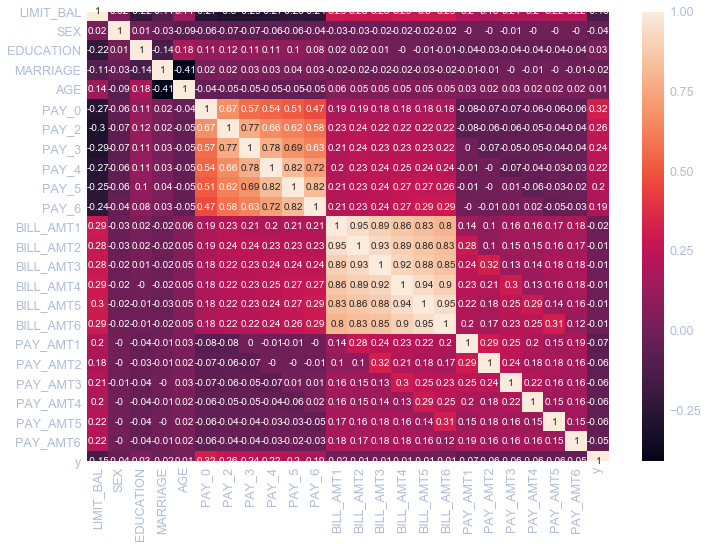

In [9]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sn.heatmap(ax=ax, data=df_scaled.corr().round(2), annot=True)


2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

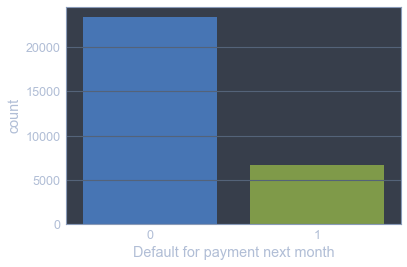

In [15]:
sn.countplot("y", data=df)

plt.xlabel("Default for payment next month")
df["EDUCATION"].value_counts()

In [20]:
df.groupby("y").mean()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
y,,,,,,,,,,,,,,,,,,,,,
0,178099.726074,1.614150,1.841337,1.558637,35.417266,-0.211222,-0.301917,-0.316256,-0.355633,-0.389488,...,47533.365605,43611.165254,40530.445343,39042.268704,6307.337357,6640.465074,5753.496833,5300.529319,5248.220296,5719.371769
1,130109.656420,1.567058,1.894665,1.528029,35.725738,0.668174,0.458258,0.362116,0.254521,0.167872,...,45181.598855,42036.950573,39540.190476,38271.435503,3397.044153,3388.649638,3367.351567,3155.626733,3219.139542,3441.482068


Text(0, 0.5, 'Frequency of Purchase')

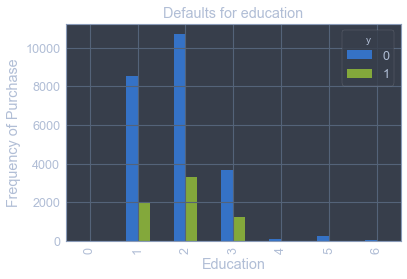

In [24]:
pd.crosstab(df.EDUCATION,df.y).plot(kind='bar')
plt.title('Defaults for education')
plt.xlabel('Education')
plt.ylabel('Frequency of Purchase')
#plt.savefig('purchase_fre_job')

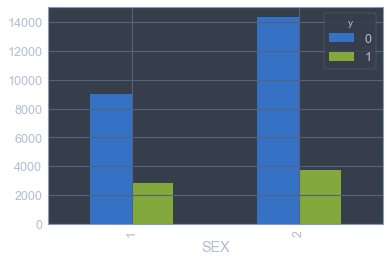

In [12]:
pd.crosstab(df.SEX,df.y).plot(kind='bar')

In [83]:
gendervalues = [1, 2]
educationvalues = [1, 2, 3, 4]
maritalstatusvalues = [1, 2, 3]
pastpaymentvalues = np.arange(-1, 10)

In [27]:
X = df_scaled.loc[:, df.columns != 'y'].values
y = df_scaled.loc[:, df.columns == 'y'].values

onehotencoder = OneHotEncoder(categories="auto")

X = ColumnTransformer(
    [("", onehotencoder, [3]),],
    remainder="passthrough"
).fit_transform(X)

X = np.c_[np.ones((X.shape[0])), X]
y = y.ravel()

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

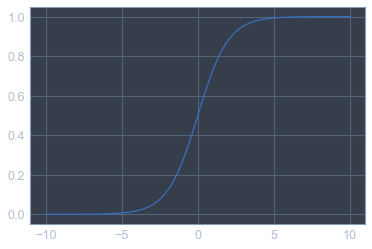

In [4]:
sigmoid = lambda t: np.exp(t)/(1 + np.exp(t))
t = np.linspace(-10, 10, 100)
plt.plot(t, sigmoid(t))

In [2]:
np.random.seed(2212)
class LogReg(object):
    def __init__(self, nfeatures):
        """Shape should be a tuple with (nsamples, nfeatures)"""
        
        self.nfeatures = nfeatures
        self.beta = np.ones(nfeatures) # coefficients of the model
        
        
    def SGD(self, X, y, epochs, eta, minibatch_size):
        """
        Perform a stochastic gradient descent in ordet to optimize the coefficients

        X: training data, should be of shape (nsamples, nfeatures)
        y: corresponding output from X, shape (nsamples)
        epochs: no. of gradient descent iterations
        eta: learning rate
        minibatch_size: size of each minibatch
        """
    
        lossHistory = np.empty(epochs)
        for j in range(epochs):
            epochLoss = 0.
            X, y = shuffle(X, y, random_state=0)

            for k in range(minibatch_size):
                xbatch = X[k]; ybatch = y[k]

                preds = sigmoid(xbatch @ self.beta) # fitted/predicted values

                #error = ybatch - preds
                error = self.costfunc(xbatch, ybatch)
                loss = np.sum(error**2)
                epochLoss += loss

                #gradient = -xbatch * error # calculate the gradients
                gradient = self.costfunc_prime(xbatch, ybatch)
                self.beta += -eta*gradient # update the parameters

            lossHistory[j] = epochLoss/epochs
            #print(f"Epoch {j+1} finished")

        return lossHistory

    def costfunc(self, x, y):
        """
        Cost function/cross entropy
        x: input vector of size nsamples
        y: output from x, 0 or 1
        -------------------------
        returns:
        C(beta) for current beta values
        """

        dotprod = x @ self.beta
        return -((y*dotprod) - np.log(1 + np.exp(dotprod)))
    

    def costfunc_prime(self, x, y):
        """
        Gradient of the cost function
        """
        
        p = self.predict(x)
        return -x.T * (y - p)
    
    def accuracy(self, X, y):
        """
        Calculate the accuracy of the model 
        X: test data of shape (nsamples, nfeatures)
        y: output from X
        """

        preds = self.predict(X, y)
        
        counter = 0
        for i in range(len(preds)):
            if np.abs(preds[i] - y[i]) < 1e-8:
                counter += 1
        
        return counter/len(preds)
    
    def predict(self, X):
        """
        Evaluate the model on test data
        
        X: test data of shape (nsamples, nfeatures)
        y: output from X of shape (nsamples)
        """
    
        preds = sigmoid(X @ self.beta)
        return preds
        
sigmoid = lambda t: np.exp(t)/(1 + np.exp(t))

# Sigmoid gives likelihood for given event

(1000,)


array([-4.68264868,  1.55416379])

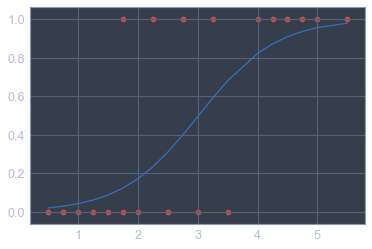

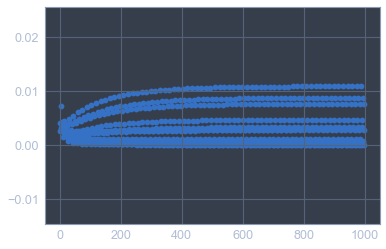

In [7]:
def exam_example(epochs, eta):
    y = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]).reshape(-1, 1)
    x1 = np.ones(len(y)).reshape(-1, 1)
    x2 = np.array([0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 1.75, 2.0, 2.25, 2.50, 2.75, 3.0,
                  3.25, 3.5, 4., 4.25, 4.5, 4.75, 5., 5.5])
    
    X = np.column_stack((x1, x2))
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)
    logreg = LogReg(X.shape[1])
    
    
    error = logreg.SGD(Xtrain, ytrain, epochs, eta, 5)
    plt.plot(x2, sigmoid(X @ logreg.beta))
    plt.scatter(x2, y, color="r")
    
    plt.figure()
    plt.scatter(np.arange(1, epochs), error[1:])
    return logreg.beta

exam_example(1000, 0.1)

In [46]:
def scikit_logreg(X, y):
    
    Xtrain, ytrain, Xtest, ytest = train_test_split(X, y, test_size=0.2, random_state=0)
    logreg = LogisticRegression()
    logreg.fit(Xtrain, ytrain)
    ypred = logreg.predict(Xtest)

    counter = 0
    for j in range(len(ypred)):
        if np.abs(ypred[j] - y[j]) < 1e-10:
            counter += 1

 